In [ ]:
import pandas as pd
import datetime as dt
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Conv1D, LSTM, Flatten
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
from keras.layers import Reshape
from keras.layers import BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset/NEW/data/btc.csv", parse_dates=True, index_col="formatted_date")
df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
2019-01-01,3850.913818,3707.231201,3746.713379,3843.520020,4324200990,3843.520020
2019-01-02,3947.981201,3817.409424,3849.216309,3943.409424,5244856836,3943.409424
2019-01-03,3935.685059,3826.222900,3931.048584,3836.741211,4530215219,3836.741211
2019-01-04,3865.934570,3783.853760,3832.040039,3857.717529,4847965467,3857.717529
2019-01-05,3904.903076,3836.900146,3851.973877,3845.194580,5137609824,3845.194580


In [ ]:
# Process data
df['H-L'] = df['high'] - df['low']
# df['O-C'] = df['open'] - df['close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['close'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['close'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['close'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['close'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['close'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv("bitcoin_processed_7_3.csv")
df

,high,low,open,close,volume,adjclose,H-L,SMA_7,SMA_14,SMA_21,SD_7,SD_21
formatted_date,,,,,,,,,,,,
2019-01-21,3608.840820,3558.537109,3600.372803,3576.032471,5004347059,3576.032471,50.303711,3646.814279,3705.745762,3776.614490,50.412745,165.766144
2019-01-22,3620.746582,3539.721436,3575.081299,3604.577148,5313623556,3604.577148,81.025146,3643.085972,3675.297852,3765.236258,52.717606,169.110917
2019-01-23,3623.067871,3565.313965,3605.557129,3585.123047,5433755649,3585.123047,57.753906,3633.102574,3643.142613,3748.175002,56.560870,168.308098
2019-01-24,3616.087402,3569.092773,3584.500244,3600.865479,5262869046,3600.865479,46.994629,3622.002790,3637.566964,3736.942825,53.704202,169.964561
2019-01-25,3612.927734,3575.597412,3607.390381,3599.765869,5265847539,3599.765869,37.330322,3613.706578,3631.309849,3724.659412,51.693454,170.120767
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-02,24167.210938,23468.595703,23720.824219,23471.871094,32066936882,23471.871094,698.615234,23294.206752,23068.255580,22325.189360,363.472764,1142.123794
2023-02-03,23678.103516,23279.955078,23469.412109,23449.322266,27083066007,23449.322266,398.148438,23347.148717,23123.453404,22493.748791,353.714738,1022.759883
2023-02-04,23556.949219,23291.794922,23446.320312,23331.847656,15639298538,23331.847656,265.154297,23390.114118,23163.040737,22605.917783,326.114352,976.122210


In [ ]:
pre_day = 7
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['high', 'low', 'open', 'H-L', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['close']
scaled_data_x = scala_x.fit_transform(df[cols_x].values)
scaled_data_y = scala_y.fit_transform(df[cols_y].values)

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


295
(1176, 7, 9) (1176, 1) (295, 7, 9) (295, 1)


In [ ]:
def create_model(drop, input_shape, units):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(LSTM(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
param_grid = {
    'drop': [0.1,0.15,0.2, 0.3, 0.4],
    'input_shape': [(3,9), (5,9), (7,9), (10,9), (20,9)],
    'units': [1,2,3,4,5,6,32,64]
}

In [ ]:
model = KerasRegressor(build_fn=create_model, verbose=0)

<ipython-input-36-8d2d8e794dbc>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

In [ ]:
grid_search.fit(X=x_train, y=y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
800 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/keras/wrappers/scikit_learn.py", line 175, in fit
    history = self.model.fit(x, y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f6c0456bc40>,
             param_grid={'drop': [0.1, 0.15, 0.2, 0.3, 0.4],
                         'input_shape': [(3, 9), (5, 9), (7, 9), (10, 9),
                                         (20, 9)],
                         'units': [1, 2, 3, 4, 5, 6, 32, 64]})

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
print("Best parameter: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameter:  {'drop': 0.2, 'input_shape': (7, 9), 'units': 3}
Best score:  -0.06648499853909015


In [ ]:
final_model = create_model(drop=best_params['drop'],  input_shape=best_params['input_shape'], units = best_params['units'])

In [ ]:
final_model.fit(x_train, y_train, epochs=500, batch_size=32)

Epoch 1/500
37/37 [==============================] - 5s 10ms/step - loss: 0.6905
Epoch 2/500
37/37 [==============================] - 0s 11ms/step - loss: 0.3973
Epoch 3/500
37/37 [==============================] - 0s 10ms/step - loss: 0.3613
Epoch 4/500
37/37 [==============================] - 0s 9ms/step - loss: 0.3058
Epoch 5/500
37/37 [==============================] - 0s 9ms/step - loss: 0.2374
Epoch 6/500
37/37 [==============================] - 0s 8ms/step - loss: 0.2036
Epoch 7/500
37/37 [==============================] - 0s 8ms/step - loss: 0.1633
Epoch 8/500
37/37 [==============================] - 0s 8ms/step - loss: 0.1517
Epoch 9/500
37/37 [==============================] - 0s 9ms/step - loss: 0.1110
Epoch 10/500
37/37 [==============================] - 0s 8ms/step - loss: 0.1041
Epoch 11/500
37/37 [==============================] - 0s 8ms/step - loss: 0.0777
Epoch 12/500
37/37 [==============================] - 0s 9ms/step - loss: 0.0677
Epoch 13/500
37/37 [==============

In [ ]:
# Testing
predict_price = final_model.predict(x_test)
predict_price = scala_y.inverse_transform(predict_price)

10/10 [==============================] - 1s 6ms/step


In [ ]:
# real_price

(295, 1)


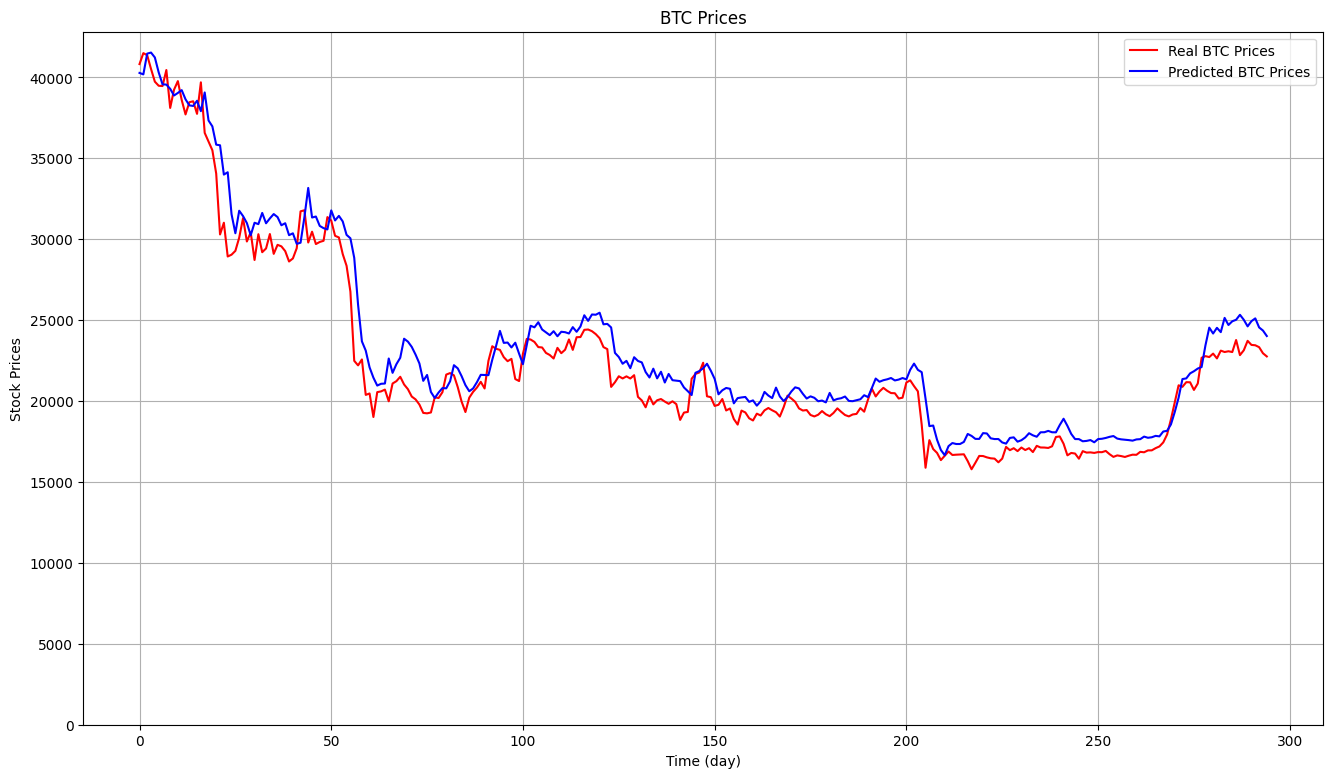

In [ ]:
# Ploting the stat
real_price = df[len(df)-test_size:]['close'].values.reshape(-1,1)
real_price = np.array(real_price)
print(real_price.shape)
real_price = real_price.reshape(real_price.shape[0], 1)
# predict_price_new=predict_price[0:len(real_price),1]
predict_price_new = predict_price[0:len(real_price), 0]

plt.figure(figsize=(16,9))
plt.grid(True)
plt.plot(real_price, color="red", label=f"Real BTC Prices")
plt.plot(predict_price_new, color="blue", label=f"Predicted BTC Prices")
plt.title(f"BTC Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [ ]:
# Make Prediction
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

prediction = final_model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 49ms/step
[[24027.795]]


In [ ]:
mae = mean_absolute_error(real_price, predict_price_new)
mape = mean_absolute_percentage_error(real_price, predict_price_new)
mse = mean_squared_error(real_price, predict_price_new)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predict_price_new)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape * 100:.4f}%")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-Squared: {r2*100:.4f}%")

MAE: 1191.1089
MAPE: 5.5228%
MSE: 2127551.0651
RMSE: 1458.6127
R-Squared: 93.9622%


In [ ]:
loss = final_model.evaluate(x_test, y_test)
print("Loss: ", loss)

10/10 [==============================] - 0s 4ms/step - loss: 5.1672e-04
Loss:  0.0005167155177332461
